In [2]:
!pip install tensorflow

In [3]:
# All imports here
import copy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [4]:
# Different Model paths
model_2M_path = "/content/drive/MyDrive/Sudoku_Solver/data/model_{2M}_{15E}_{92A}.h5"
model_1M_path = "/content/drive/MyDrive/Sudoku_Solver/data/model_{1M}_{32E}_{87A}.h5"
model_15L_path = "/content/drive/MyDrive/Sudoku_Solver/data/model_15Layer_1M.h5"

In [5]:
# Data Set path
one_million_path = "/content/drive/MyDrive/Sudoku_Solver/data/1Million.csv"

In [6]:
data_df = pd.read_csv(one_million_path)

In [7]:
data_df.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


In [8]:
def train_test_split_data(df, test_ratio=0.2): 

    questions = []
    solutions = []

    # Process questions and solutions
    for idx, row in df.iterrows():
      # Pre process question
      question = row['quizzes']
      question = (np.array(list(map(int,list(question)))).reshape((9,9,1))/9) - 0.5
      questions.append(question)

      # Pre process solutions
      solution = row['solutions']
      solution = (np.array(list(map(int,list(solution)))).reshape(81, 1)) - 1
      solutions.append(solution)

    x_train, x_test, y_train, y_test = train_test_split(np.array(questions), np.array(solutions), test_size=test_ratio, random_state=42)

    del(questions)
    del(solutions)
    
    return x_train, x_test, y_train, y_test

In [9]:
x_train, x_test, y_train, y_test = train_test_split_data(data_df)

In [10]:
n_test_samples = 200

## Backtrack Solver

In [11]:
class Backtrack:

    def solve_sudoku(self, board):
        if self.backtrack(board, 0, 0):
          return True
        return False

    def denormalize(self,a):
      return (a+.5)*9
                    
    def backtrack(self, board, r: int, c: int) -> bool:
        # Go to next empty space
        while board[r][c] != 0:
            c += 1
            if c == 9: c, r = 0, r+1
            if r == 9: return True
        # Try all options, backtracking if not work
        for k in range(1, 10):
            if self.is_valid_sudoku_move(board, r, c, k):
                board[r][c] = k
                if self.backtrack(board, r, c):
                    return True
        board[r][c] = 0
        return False
    
    def is_valid_sudoku_move(self, board, r: int, c: int, cand: int) -> bool:
        # Check row
        if any(board[r][j] == cand for j in range(9)): return False
        # Check col
        if any(board[i][c] == cand for i in range(9)): return False
        # Check block
        br, bc = 3*(r//3), 3*(c//3)
        if any(board[i][j] == cand for i in range(br, br+3) for j in range(bc, bc+3)): return False
        return True

In [12]:
def evaluate_backtrack(x_test):

  backtrack = Backtrack()
  backtrack_test = backtrack.denormalize(x_test)
  start = datetime.now()
  print(backtrack_test.shape)

  time_taken = []
  for i, puzzle in enumerate(backtrack_test):
    backtrack.solve_sudoku(puzzle.reshape(9,9))
    if (i+1)%10==0 or i+1==x_test.shape[0]: 
      delta = (datetime.now()-start).total_seconds()
      print(f"Solved {i+1} sudoku's in {delta} seconds")
      time_taken.append(delta)

  print("Total Time taken: ", datetime.now()-start)
  return time_taken

In [13]:
# Get the list of backtrack time taken for each 10 puzzles
backtrack_time = evaluate_backtrack(x_test[0:n_test_samples])

(200, 9, 9, 1)
Solved 10 sudoku's in 0.098246 seconds
Solved 20 sudoku's in 0.192908 seconds
Solved 30 sudoku's in 0.353112 seconds
Solved 40 sudoku's in 0.441021 seconds
Solved 50 sudoku's in 0.514999 seconds
Solved 60 sudoku's in 0.599911 seconds
Solved 70 sudoku's in 0.705802 seconds
Solved 80 sudoku's in 0.812256 seconds
Solved 90 sudoku's in 0.941815 seconds
Solved 100 sudoku's in 1.026734 seconds
Solved 110 sudoku's in 1.078308 seconds
Solved 120 sudoku's in 1.152931 seconds
Solved 130 sudoku's in 1.280396 seconds
Solved 140 sudoku's in 1.333961 seconds
Solved 150 sudoku's in 1.674697 seconds
Solved 160 sudoku's in 1.776054 seconds
Solved 170 sudoku's in 1.834856 seconds
Solved 180 sudoku's in 1.906371 seconds
Solved 190 sudoku's in 1.988832 seconds
Solved 200 sudoku's in 2.064344 seconds
Total Time taken:  0:00:02.064525


In [14]:
backtrack_time[:3]

[0.098246, 0.192908, 0.353112]

## Neural network solvers

In [15]:
class SudokuCNN:

  def get_accuracy_and_time_taken(self, feats, labels, model): 
    start = datetime.now()
    correct = 0
    time_taken = []
    for i, feat in enumerate(feats): 
      pred = self.inference_sudoku(feat, model)
      true = labels[i].reshape((9,9))+1
      if(abs(true - pred).sum()==0):
          correct += 1 
      if (i+1)%10==0 or i+1==feats.shape[0]:
        delta = (datetime.now()-start).total_seconds()
        print(f"Solved {i+1} sudoku's in {delta} seconds")
        time_taken.append(delta)

    accuracy = correct/feats.shape[0]      
    print("Accuracy:", accuracy)
    print("Total Time taken:", datetime.now()-start)
    return time_taken, accuracy

  def denormalize(self,a):
      return (a+.5)*9

  def normalize(self,a):
      return (a/9)-.5

  def inference_sudoku(self,sample, model):
    feat = copy.copy(sample)
    while(1):
      out = model.predict(feat.reshape((1,9,9,1)))  
      out = out.squeeze()

      pred = np.argmax(out, axis=1).reshape((9,9))+1 
      prob = np.around(np.max(out, axis=1).reshape((9,9)), 2) 
      
      feat = self.denormalize(feat).reshape((9,9))
      mask = (feat==0)
    
      if(mask.sum()==0):
          break
          
      prob_new = prob*mask

      ind = np.argmax(prob_new)
      x, y = (ind//9), (ind%9)

      val = pred[x][y]
      feat[x][y] = val
      feat = self.normalize(feat)
    
    return pred

In [16]:
# Initialize the CNN Solver
sudoku_predictor = SudokuCNN()

In [17]:
# Model 1: Model trained on one million data set
model1 = load_model(model_1M_path)

In [18]:
# Get the time
model1_time,model1_accuracy = sudoku_predictor.get_accuracy_and_time_taken(x_test[:n_test_samples], y_test[:n_test_samples], model1)

Solved 10 sudoku's in 33.391344 seconds
Solved 20 sudoku's in 59.412251 seconds
Solved 30 sudoku's in 85.100541 seconds
Solved 40 sudoku's in 111.806929 seconds
Solved 50 sudoku's in 138.083492 seconds
Solved 60 sudoku's in 164.162111 seconds
Solved 70 sudoku's in 190.361698 seconds
Solved 80 sudoku's in 215.82991 seconds
Solved 90 sudoku's in 241.595141 seconds
Solved 100 sudoku's in 267.373349 seconds
Solved 110 sudoku's in 293.459895 seconds
Solved 120 sudoku's in 320.109937 seconds
Solved 130 sudoku's in 349.047815 seconds
Solved 140 sudoku's in 375.585318 seconds
Solved 150 sudoku's in 401.846735 seconds
Solved 160 sudoku's in 428.277555 seconds
Solved 170 sudoku's in 454.56682 seconds
Solved 180 sudoku's in 480.726469 seconds
Solved 190 sudoku's in 506.360747 seconds
Solved 200 sudoku's in 532.604184 seconds
Accuracy: 0.94
Total Time taken: 0:08:52.605091


In [19]:
model1_time[:3]

[33.391344, 59.412251, 85.100541]

In [20]:
# Model 2: Model trained on two million data set
model2 = load_model(model_2M_path)

In [21]:
# Get the time
model2_time,model2_accuracy = sudoku_predictor.get_accuracy_and_time_taken(x_test[:n_test_samples], y_test[:n_test_samples], model2)

Solved 10 sudoku's in 26.711033 seconds
Solved 20 sudoku's in 53.744982 seconds
Solved 30 sudoku's in 80.418839 seconds
Solved 40 sudoku's in 105.835466 seconds
Solved 50 sudoku's in 132.34573 seconds
Solved 60 sudoku's in 158.693557 seconds
Solved 70 sudoku's in 184.947959 seconds
Solved 80 sudoku's in 210.535296 seconds
Solved 90 sudoku's in 236.448283 seconds
Solved 100 sudoku's in 263.174127 seconds
Solved 110 sudoku's in 289.803419 seconds
Solved 120 sudoku's in 316.087105 seconds
Solved 130 sudoku's in 342.291329 seconds
Solved 140 sudoku's in 368.584094 seconds
Solved 150 sudoku's in 395.204321 seconds
Solved 160 sudoku's in 422.051848 seconds
Solved 170 sudoku's in 448.316804 seconds
Solved 180 sudoku's in 474.148654 seconds
Solved 190 sudoku's in 500.972116 seconds
Solved 200 sudoku's in 526.801795 seconds
Accuracy: 1.0
Total Time taken: 0:08:46.802471


In [22]:
# Model 3: 15 Layer architecture
model3 = load_model(model_15L_path)

In [23]:
# Get the time
model3_time, model3_accuracy = sudoku_predictor.get_accuracy_and_time_taken(x_test[:n_test_samples], y_test[:n_test_samples], model3)

Solved 10 sudoku's in 29.354204 seconds
Solved 20 sudoku's in 58.069137 seconds
Solved 30 sudoku's in 85.898629 seconds
Solved 40 sudoku's in 113.665608 seconds
Solved 50 sudoku's in 141.394844 seconds
Solved 60 sudoku's in 168.794342 seconds
Solved 70 sudoku's in 197.024347 seconds
Solved 80 sudoku's in 223.841771 seconds
Solved 90 sudoku's in 251.830491 seconds
Solved 100 sudoku's in 279.679881 seconds
Solved 110 sudoku's in 307.214075 seconds
Solved 120 sudoku's in 334.671583 seconds
Solved 130 sudoku's in 362.039405 seconds
Solved 140 sudoku's in 389.593714 seconds
Solved 150 sudoku's in 417.663808 seconds
Solved 160 sudoku's in 445.847206 seconds
Solved 170 sudoku's in 473.056532 seconds
Solved 180 sudoku's in 501.061746 seconds
Solved 190 sudoku's in 529.482229 seconds
Solved 200 sudoku's in 557.151756 seconds
Accuracy: 0.91
Total Time taken: 0:09:17.152512


### Plot the time comparison graphs

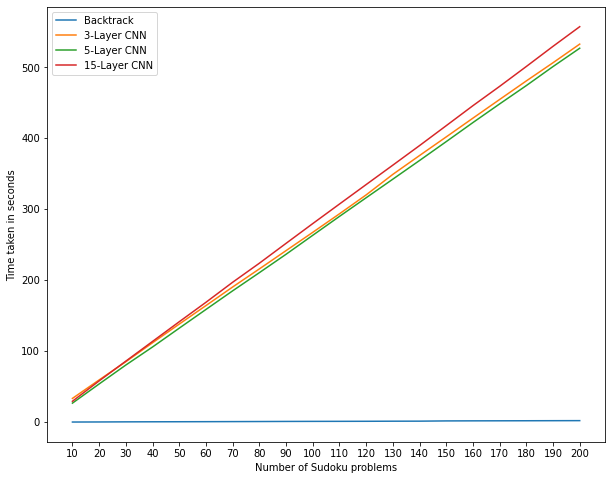

In [26]:
# Backtrack graph
x_axis_range = range(10,int(n_test_samples)+10,10)
plt.figure(figsize=(10, 8))
plt.xticks(x_axis_range)
plt.plot(x_axis_range, backtrack_time)
plt.plot(x_axis_range, model1_time)
plt.plot(x_axis_range, model2_time)
plt.plot(x_axis_range, model3_time)
plt.legend(["Backtrack", "3-Layer CNN", "5-Layer CNN", "15-Layer CNN"])
plt.xlabel('Number of Sudoku problems')
plt.ylabel('Time taken in seconds')
plt.show()

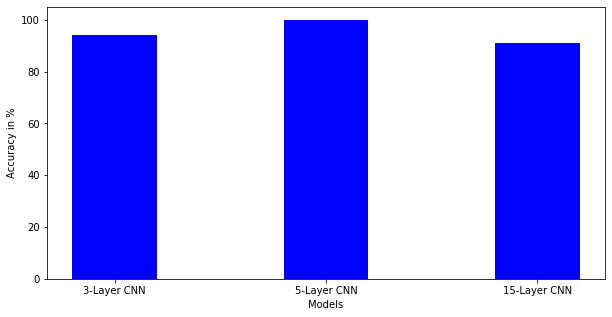

In [25]:
model_names = ["3-Layer CNN", "5-Layer CNN", "15-Layer CNN"]
model_accuracies = [model1_accuracy*100, model2_accuracy*100, model3_accuracy*100]

fig = plt.figure(figsize = (10, 5))
 
plt.bar(model_names, model_accuracies, color ='blue',
        width = 0.4)

plt.ylabel('Accuracy in %')
plt.xlabel('Models')

plt.show()